In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy.stats import pearsonr
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from scipy import stats
from scipy.signal import convolve,deconvolve
from sympy import *
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
import warnings
import matplotlib.cbook
import string
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                    'GROWTH_HORMONE_GH':'GH',
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                     'CORTISOL_U_FREE_24h':'Urinary cortisol',
                     'T3_FREE':'T3-free',
                     'T4_FREE':'T4-free',
                     'ESTRADIOL_E_2':'Estradiol',
                     'TESTOSTERONE_TOTAL':'Testosterone',
                     'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ 'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'PROGESTERONE'           :'P4'}

pituitary_unit_dict = {'ACTH':'Percentile',
                       'TSH' :'Percentile',
                       'LH'  :'Percentile',
                       'FSH' :'Percentile',
                       'Prolactin':'Percentile',
                       'GH'  :'Percentile'}

effector_unit_dict  = {'Cortisol':'Percentile',
                       'Urinary cortisol':'Percentile',
                       'T3-free':'Percentile',
                       'T4-free':'Percentile',
                       'Estradiol':'Percentile',
                       'Testosterone': 'Percentile',
                       'IGF1' :'Percentile'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                    'CREATININE_BLOOD':'Creatinine',
                    'Cl':'Cl',
                    'GLUCOSE_BLOOD':'Glucose',
                    'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                    'HGB':'HGB',
                    'MAGNESIUM_BLOOD':'Mg',
                    'POTASSIUM':'K',
                    'SODIUM':'Na',
                    'UREA_BLOOD':'Urea'}
 
month_names = [x[:3] for x in calendar.month_name[1:13]]
letters     = string.ascii_uppercase

In [2]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]

#     zf = df.loc[df['age_group'] !='[70,80]'].copy()
#     zf = zf.loc[zf['age_group'] !='[60,70)']
#     zf = zf.loc[zf['age_group'] !='[50,60)'] 
#     # use ages 20-50 if there are more than 10k mesurements, if there are less, use ages 20-80
#     if np.sum(zf['n'].values)>10000:
#         df = zf

    df.loc[df['month'] == 12,['month']] = 0
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp*2,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    
    # 2st order cosinor - 4 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp*2,np.pi,maxamp*2,np.pi)])
    
    A21          = res_fit[0]
    phi21        = res_fit[1]
    A22          = res_fit[2]
    phi22        = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,hormone,sex,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)
        
    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        

        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))

        if hormone =='TESTOSTERONE_TOTAL':
            if sex =='male':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars))
                
        elif hormone =='ESTRADIOL_E_2':
            if sex =='female':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars)) 
        else:
            all_tests_acrophase  .append(get_acrophase(pars))
            all_tests_relmaxmin  .append(get_relmaxmin(pars))  

        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
        
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    print(all_tests_acrophase)
    print([aic1,aic2,aic_null])
    best_model = np.argmin(np.array([aic1,aic2,aic_null])) 
    if best_model   == 0:
        print('1st order cosinor')
        return cosinor_tables[0]
    elif best_model == 1:
        print('2nd order cosinor')
        return cosinor_tables[1]
    else:
        print('constant')
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
    
    plt.errorbar(np.arange(0,12),ydat,edat,c='k')
    
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='b')

    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='r')
    plt.xticks(ticks=np.arange(0,12))
    plt.grid()
    plt.show()
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='qunaitle'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat,hormone,sex)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='quantile'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):
            print('--------------')
            print(k,sex)
            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}
            print('acrophase = ' ,acrophase)
            print('maxmin/2 = ' ,maxmin)

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

In [4]:
# effector_list  = gen_hormone_list(effector_hormone_dic)
# pituitary_list = gen_hormone_list(pituitary_hormone_dic)

In [5]:
# residual_list  = gen_hormone_list(residual_hormone_dic)
# chem_list      = gen_hormone_list(chem_dic)

In [6]:
# pickle.dump([pituitary_list,effector_list,residual_list,chem_list],open('seasonality_processed_data1102_20_80.pickle','wb'))

In [3]:
[pituitary_list,effector_list,residual_list,chem_list] = pickle.load(open('seasonality_processed_data1102_20_80.pickle','rb'))

D:\Anaconda\envs\venv\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


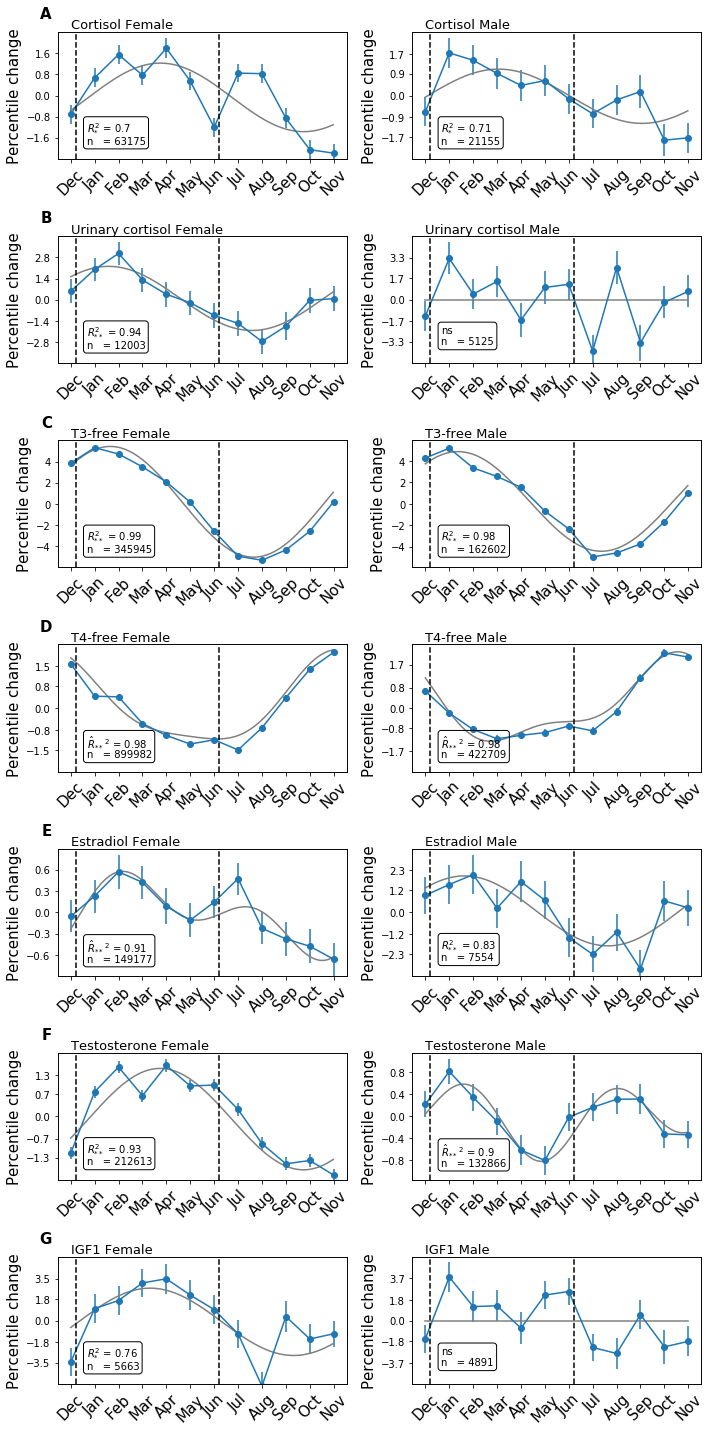

In [8]:
'''
plot effector hormones seasonality
'''
eff_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(effector_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]
                
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        eff_r2df = eff_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))
        
        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        y_percentage   = (yloc-yloc.mean())*100;
        err_precentage = err*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile change',fontsize=15)
        
        ax.tick_params(axis="y", labelsize=10)
        
        ylim = ax.get_ylim();        
        ax.set_yticks(np.round([-ylim[1]*2/3,-ylim[1]*1/3,0,ylim[1]*1/3,ylim[1]*2/3],decimals=1))
        ax.set_ylim(-ylim[1],ylim[1])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        ## x0 = Dec 15, so add 6 days to get Dec 21st
        ## in month resulotion, 6 days are 0.2 month
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/Seasonality11022020/SI_effector_subplots_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()

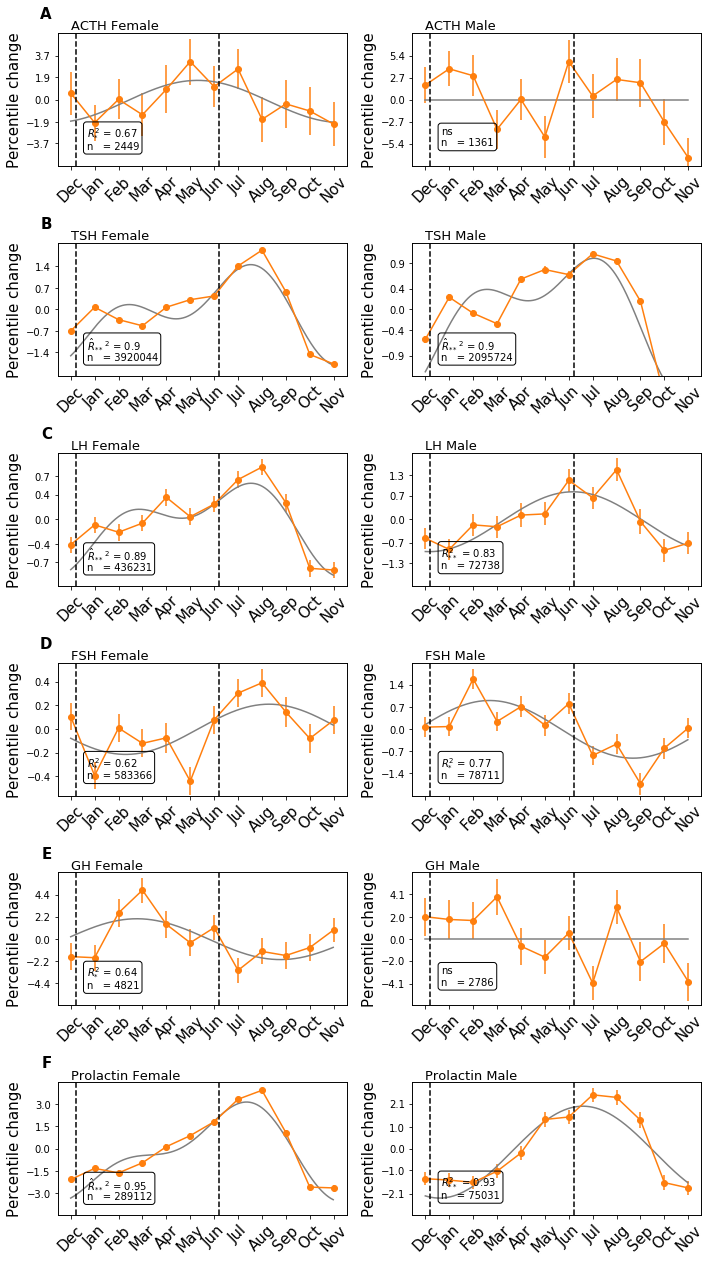

In [9]:
'''
plot pituitary hormones seasonality
'''
pit_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(pituitary_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        # months are stored iin the dataframe in a january-december fmt, 
        # this part will make december as the 0th month
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        pit_r2df = pit_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
            
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100

        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile change',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        
        ylim = ax.get_ylim();        
        ax.set_yticks(np.round([-ylim[1]*2/3,-ylim[1]*1/3,0,ylim[1]*1/3,ylim[1]*2/3],decimals=1))
        ax.set_ylim(-ylim[1],ylim[1])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/Seasonality11022020/SI_pituitary_subplots_102.pdf',bbox_inches='tight',dpi=600)
plt.show()

D:\Anaconda\envs\venv\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


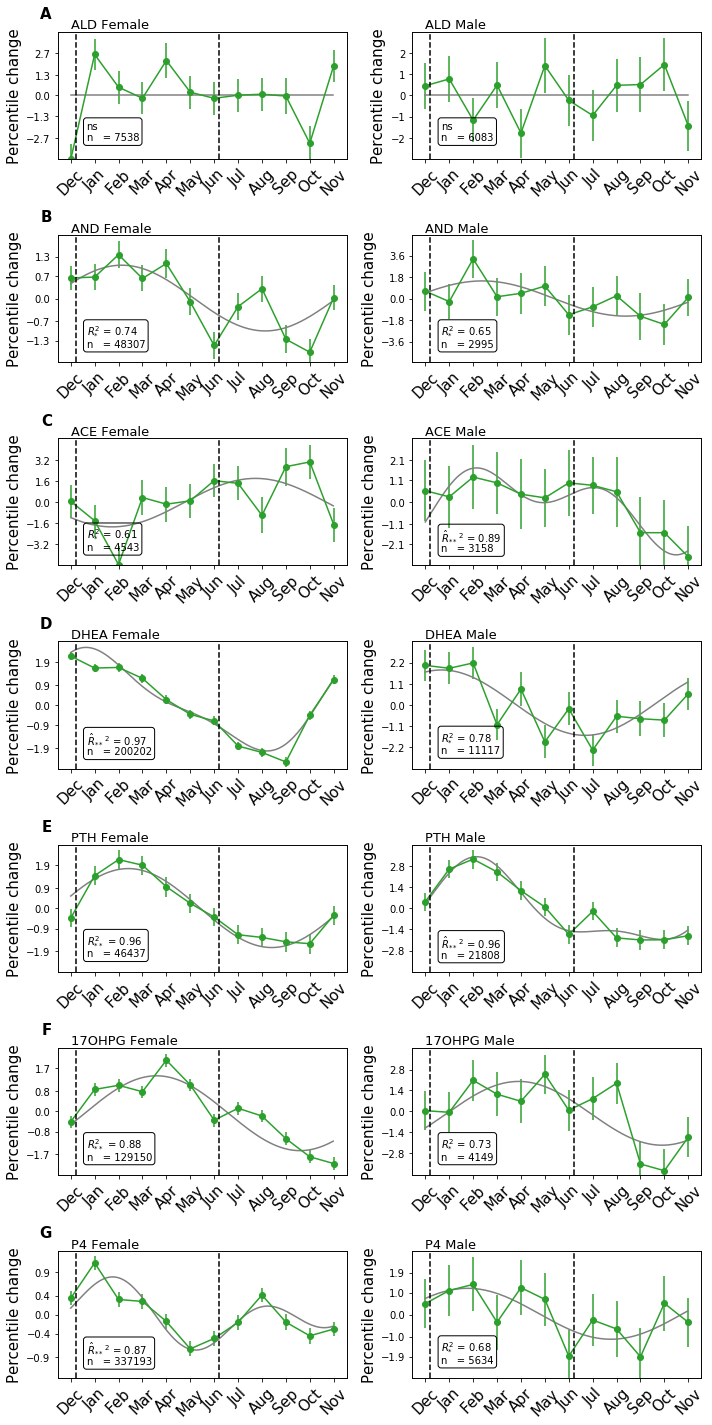

In [10]:
'''
plot residual hormones seasonality
'''
residual_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(residual_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = residual_list[residual_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        residual_r2df = residual_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100
        err_precentage = err*100

        #plot
        ax = plt.subplot(9,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[2],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile change',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        
        ylim = ax.get_ylim();        
        ax.set_yticks(np.round([-ylim[1]*2/3,-ylim[1]*1/3,0,ylim[1]*1/3,ylim[1]*2/3],decimals=1))
        ax.set_ylim(-ylim[1],ylim[1])
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(residual_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
         
plt.tight_layout()
plt.savefig('../figures/Seasonality11022020/SI_residual_subplots_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()

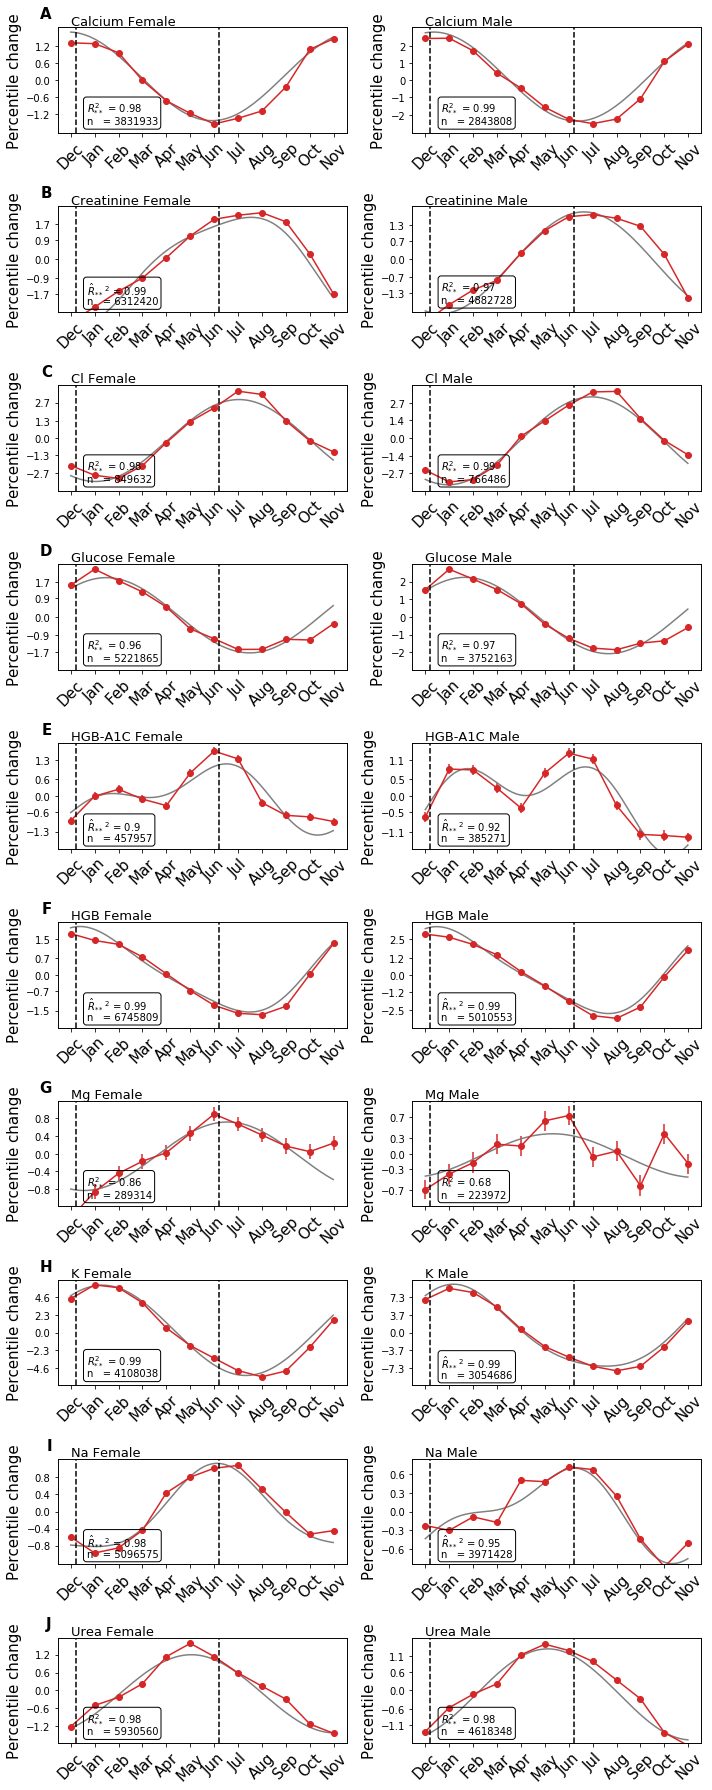

In [11]:
'''
plot chemistry seasonality
'''
chem_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(chem_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = chem_list[chem_dic[k]][sex]['Clalit']['xloc']
        yloc    = chem_list[chem_dic[k]][sex]['Clalit']['yloc']
        err     = chem_list[chem_dic[k]][sex]['Clalit']['err']
        ntot    = chem_list[chem_dic[k]][sex]['Clalit']['ntot']
        phase   = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][1]
        
        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        chem_r2df = chem_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100
        #plot
        ax = plt.subplot(10,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[3],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile change',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        
        ylim = ax.get_ylim();        
        ax.set_yticks(np.round([-ylim[1]*2/3,-ylim[1]*1/3,0,ylim[1]*1/3,ylim[1]*2/3],decimals=1))
        ax.set_ylim(-ylim[1],ylim[1])
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(chem_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
       
plt.tight_layout()
plt.savefig('../figures/Seasonality11022020/SI_chemistry_subplots_102.pdf',bbox_inches='tight',dpi=600)
plt.show()

# FIG 1 complete

In [12]:
def HPA_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('A'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('ACTH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Cortisol',[-1.12+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.725, 0.2, 0.2], anchor='SW', zorder=-1)
    
    newax.imshow(plt.imread('../figures/ppt/glands/adrenal.png'))
    
    newax.text(0.2, 1.08, 'Stress adaptation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    
    newax.text(0.2, 0.2, 'Adrenal Cortex', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    

    newax.text(0.16, 1.09, 'A', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')

    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def HPT_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('TSH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T4'   ,[-1.015+xoff ,-0.8+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('T3'   ,[-1.015+xoff ,-1.1+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.7 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.8 +Yoff],
                xy    =[-0.97  +xoff ,-1 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
       
    newax = fig.add_axes([-0.2, 0.528, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/thyroid.png'))
    
    newax.text(0.2, 1.08, 'Thermoregulation \n   & metabolism', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, 'Thyroid', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'B', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)
    
def HPG_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('G'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('LH'   ,[-0.9+xoff ,-0.15+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('FSH'  ,[-0.9+xoff ,-0.35+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Test',[-0.9+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('E2'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.357, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/gonads.png'))
    
    newax.text(0.2, 1.08, 'Reproduction', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, '  Gonads', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'C', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    

def HPL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.6     
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('L'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('GH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('IGF-1',[-1.05+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.133, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/liver.png'))
    
    newax.text(0.2, 1.08, 'Growth', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.56, '    Liver', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'D', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def PRL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.45 
    ax.annotate('H'    ,[-1   +xoff,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1   +xoff,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('PRL'  ,[-1.05+xoff,-0.45+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, 0.3 +Yoff],
                xy    =[-0.97  +xoff,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, -0.1 +Yoff],
                xy    =[-0.97  +xoff,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))

    newax = fig.add_axes([-0.2, 0.035, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/breasts.png'))
    
    newax.text(0.2, 1.08, 'Lactation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.45, '    Breasts', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'E', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    
        
def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=15,empty=False,fontsize=15):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,mec='k')
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]),fontsize=fontsize)
    

D:\Anaconda\envs\venv\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


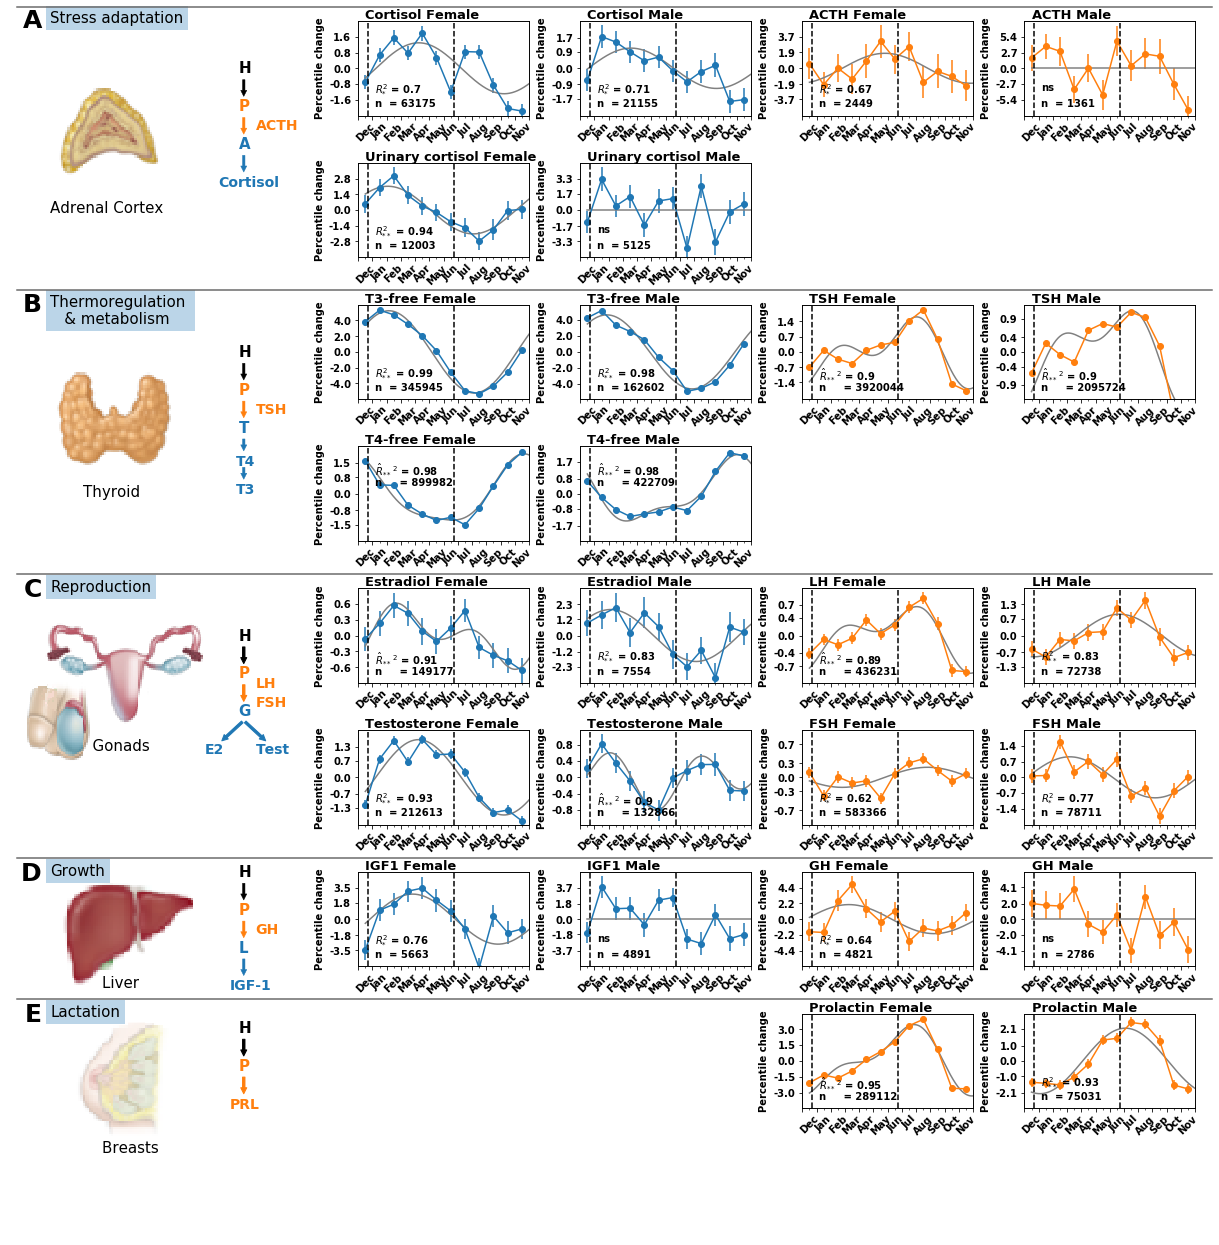

In [13]:
'''
FIG 1 -  Code to plot cosinor fit subplots
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(15,20))
gs  = fig.add_gridspec(8, 4)
ax  = fig.add_subplot(gs[0,0]); HPA_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[2,0]); HPT_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[4,0]); HPG_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[6,0]); HPL_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[7,0]); PRL_graph_on_axe(ax,fig);  ax.axis('off')
month_names0  = np.roll(month_names,1)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
           
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel('Percentile change',fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ylim = ax.get_ylim();        
        ax.set_yticks(np.round([-ylim[1]*2/3,-ylim[1]*1/3,0,ylim[1]*1/3,ylim[1]*2/3],decimals=1))
        ax.set_ylim(-ylim[1],ylim[1])
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 
            
        if k == 'T4_FREE':
            ax.text(0.1, 0.85, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.675, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        else:
            ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
             
PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)

        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100;  fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel('Percentile change',fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        if ax.get_ylim()[1]<0.7:
            ax.set_ylim([-1,1])
        
        ylim = ax.get_ylim();        
        ax.set_yticks(np.round([-ylim[1]*2/3,-ylim[1]*1/3,0,ylim[1]*1/3,ylim[1]*2/3],decimals=1))
        ax.set_ylim(-ylim[1],ylim[1])
        
        axn = ax.twinx(); axn.set_yticks([]); 
        axn.axvline(x=0.2,ls='--',c='k'); axn.axvline(x=6.2,ls='--',c='k')
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 

        ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

plt.subplots_adjust(hspace=0.5,wspace =0.3)
plt.savefig('../figures/Seasonality11022020/Figure1_1102_20_80.pdf',bbox_inches='tight',dpi  =600)
plt.show()

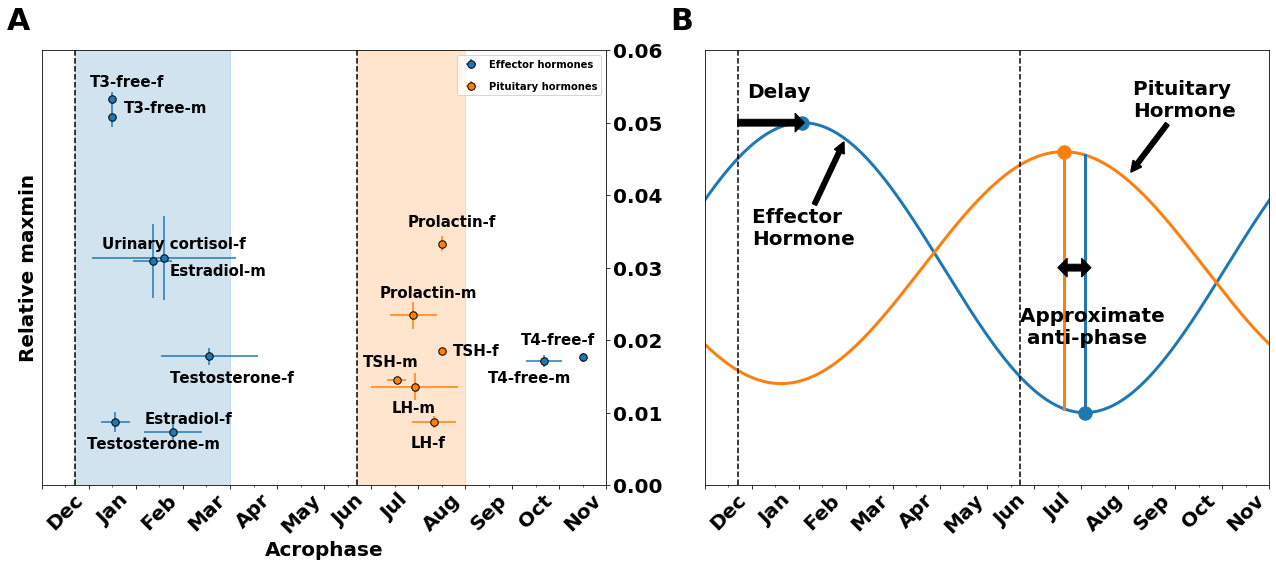

In [17]:
'''
FIG 2AB -  Code to phase plot, and summery
'''
fig = plt.figure(figsize=(22,8))
gs  = fig.add_gridspec(4, 6)

uy = 0.06/100
ux = 12/100
pit_loc = [(2*ux,-uy),(-6*ux,3*uy),(-4*ux,-6*uy),(-4*ux,-6*uy),(-6*ux,4*uy),(-6*ux,4*uy)]
eff_loc = [(-9*ux,3*uy),(ux*-4,3*uy),(ux*2,1*uy),(-11*ux,3*uy),(-10*ux,-5*uy),(-5*ux,2*uy),(ux,-4*uy),(-7*ux,-6*uy),(-5*ux,-6*uy),(-5*ux,4*uy)]

temp    = eff_r2df.loc[eff_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

temp    = pit_r2df.loc[pit_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

eff_rel_maxmin     = []
eff_acrophase      = []
eff_rel_maxmin_std = []
eff_acrophase_std  = []
eff_names          = []

for hormone in eff_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

pit_rel_maxmin     = []
pit_acrophase      = []
pit_rel_maxmin_std = []
pit_acrophase_std  = []
pit_names          = []

for hormone in pit_big:
    name = hormone[0]
    if name == 'GROWTH_HORMONE_GH':
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    sex_one_letter = sex[0]
    pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)


'''
FIG 2A -  Code to plot phase/amp 
'''
axbig = fig.add_subplot(gs[:,:3])
ax    = fig.add_subplot(gs[:,3:])

plot_phase_amp(axbig,
               np.array(eff_rel_maxmin),
               np.array(eff_acrophase), 
               np.array(eff_rel_maxmin_std),
               np.array(eff_acrophase_std),
               eff_names,
               color=def_color[0],
               loc_list=eff_loc)

plot_phase_amp(axbig,
               np.array(pit_rel_maxmin),
               np.array(pit_acrophase), 
               np.array(pit_rel_maxmin_std),
               np.array(pit_acrophase_std),
               pit_names,
               color=def_color[1],
               loc_list=pit_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
# axbig.tick_params(which='minor', length=8,labelsize =20)
# axbig.tick_params(which='major', length=0,labelsize =20)
axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

axbig.set_xticks(np.arange(12))
axbig.set_xticklabels(month_names0, rotation=45)
axbig.tick_params(axis='x',labelsize =20)
axbig.tick_params(axis='y',labelsize =20)

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 3.5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,13,1)-0.5)
axbig.set_xticklabels([])
axbig.set_xticks(np.arange(0,12,1),minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)
axbig.set_xlim([-0.5,11.5])
###########################################
###########################################
###########################################

'''
FIG 2B -  Code to calculate average effector hormones seasonality
'''
stack_eff_cos = []
stack_pit_cos = [] 
                                              
for j,hormone in enumerate(eff_big):
    name = hormone[0]
    if name in ['T3_FREE','T4_FREE']:
        continue
    sex  = hormone[1]
    acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_eff_cos.append([acrophase,relmaxmin])            
    
for j,hormone in enumerate(pit_big):
    name = hormone[0]
    if name in ['TSH_THYROID_STIMULATING_HORMONE','GROWTH_HORMONE_GH','PROLACTIN']:
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_pit_cos.append([acrophase,relmaxmin])

p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3) 

p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
# relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
pit_cos   = 1+0.8*relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)

mn = np.roll(month_names,1)
mn = np.insert(mn, 12, mn[0])
ax.set_yticks([])

ax.set_xticks(0.5+np.arange(12))
ax.set_xticklabels(mn, rotation=45)
ax.set_xlim([0,12])
ax.set_ylim([1-relmaxmin*1.5,1+relmaxmin*1.5])

ax.tick_params(axis='x',labelsize =20)

ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.85, 0,head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.annotate('Delay',[0.9,1.0225],fontsize=20)

ax.annotate('Pituitary \nHormone',fontsize=20,
            xy=(9, pit_cos[9*30]), xycoords='data',
            xytext=(9.1, 1.02), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.annotate('Effector \nHormone',fontsize=20,
            xy=(3, eff_cos[3*30]), xycoords='data',
            xytext=(1, 1.003), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.scatter(eff_cos.argmax()*12/365, eff_cos.max(),s=180,c=def_color[0])
ax.scatter(eff_cos.argmin()*12/365, eff_cos.min(),s=180,c=def_color[0])
ax.scatter(pit_cos.argmax()*12/365, pit_cos.max(),s=180,c=def_color[1])

ax.plot([pit_cos.argmax()*12/365,pit_cos.argmax()*12/365],[pit_cos.max(),eff_cos[pit_cos.argmax()]],c=def_color[1],lw='3')
ax.plot([eff_cos.argmin()*12/365,eff_cos.argmin()*12/365],[eff_cos.min(),pit_cos[eff_cos.argmin()]],c=def_color[0],lw='3')

ax.annotate('Approximate \n anti-phase',[6.7,0.99],fontsize=20)

mid    = np.mean([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])
ar_len = np.diff([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])[0]/3

ax.arrow(mid, 1, ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.arrow(mid, 1, -ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)

ax.text(-0.02, 1.1, 'B', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax.axvline(x=0.7,ls='--',c='k')
ax.axvline(x=6.7,ls='--',c='k')

ax.set_xticks(np.arange(0,13,1))
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)

plt.subplots_adjust(hspace=0.4,wspace =0.8)
plt.savefig('../figures/Seasonality11022020/Figure2_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()

In [18]:
# '''
# FIG 2AB -  Code to phase plot, and summery
# '''
# fig = plt.figure(figsize=(24,6))
# gs  = fig.add_gridspec(4, 9)

# uy = 0.06/100
# ux = 12/100
# pit_loc = [(2*ux,-uy),(-6*ux,3*uy),(-4*ux,-6*uy),(-4*ux,-6*uy),(-6*ux,4*uy),(-6*ux,4*uy)]
# eff_loc = [(-9*ux,3*uy),(ux*-4,3*uy),(ux*2,1*uy),(-11*ux,3*uy),(-10*ux,-5*uy),(-5*ux,2*uy),(ux,-4*uy),(2*ux,-4*uy),(-5*ux,-6*uy),(-5*ux,4*uy)]

# temp    = eff_r2df.loc[eff_r2df['sex']!='both']
# temp    = temp[temp['r2']>0.8]
# eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

# temp    = pit_r2df.loc[pit_r2df['sex']!='both']
# temp    = temp[temp['r2']>0.8]
# pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

# eff_rel_maxmin     = []
# eff_acrophase      = []
# eff_rel_maxmin_std = []
# eff_acrophase_std  = []
# eff_names          = []

# for hormone in eff_big:
#     name = hormone[0]
#     sex  = hormone[1]
#     sex_one_letter = sex[0]
#     eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
#     eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
#     eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
#     eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
#     eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

# pit_rel_maxmin     = []
# pit_acrophase      = []
# pit_rel_maxmin_std = []
# pit_acrophase_std  = []
# pit_names          = []

# for hormone in pit_big:
#     name = hormone[0]
#     if name == 'GROWTH_HORMONE_GH':
#         continue    
#     sex  = hormone[1]
#     if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
#         if sex =='male':
#             continue
#     sex_one_letter = sex[0]
#     pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
#     pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
#     pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
#     pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
#     pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)


# '''
# FIG 2A -  Code to plot phase/amp 
# '''
# axbig = fig.add_subplot(gs[:,:3])
# ax    = fig.add_subplot(gs[:,3:6])

# plot_phase_amp(axbig,
#                np.array(eff_rel_maxmin),
#                np.array(eff_acrophase), 
#                np.array(eff_rel_maxmin_std),
#                np.array(eff_acrophase_std),
#                eff_names,
#                color=def_color[0],
#                loc_list=eff_loc,fontsize=13)


# plot_phase_amp(axbig,
#                np.array(pit_rel_maxmin),
#                np.array(pit_acrophase), 
#                np.array(pit_rel_maxmin_std),
#                np.array(pit_acrophase_std),
#                pit_names,
#                color=def_color[1],
#                loc_list=pit_loc,fontsize=13)

# month_names0  = np.roll(month_names,1)
# axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
# axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
# axbig.yaxis.tick_right()
# # axbig.tick_params(which='minor', length=8,labelsize =20)
# # axbig.tick_params(which='major', length=0,labelsize =20)
# axbig.set_ylim((0,0.06))
# axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
# axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
# axbig.set_xlim([-0.5,11.5])
# axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# axbig.set_xticks(np.arange(12))
# axbig.set_xticklabels(month_names0, rotation=45)
# axbig.tick_params(axis='x',labelsize =20)
# axbig.tick_params(axis='y',labelsize =20)

# axbig.axvline(x=0.2,ls='--',c='k')
# axbig.axvspan(0.2, 4.5  , alpha=0.2, color=def_color[0])
# axbig.axvline(x=6.2,ls='--',c='k')
# axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])

# axbig.set_xticks(np.arange(0,13,1)-0.5)
# axbig.set_xticklabels([])
# axbig.set_xticks(np.arange(0,12,1),minor=True)
# axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)
# axbig.set_xlim([-0.5,11.5])
# ###########################################
# ###########################################
# ###########################################

# '''
# FIG 2B -  Code to calculate average effector hormones seasonality
# '''
# stack_eff_cos = []
# stack_pit_cos = [] 
                                              
# for j,hormone in enumerate(eff_big):
#     name = hormone[0]
#     if name in ['T3_FREE','T4_FREE']:
#         continue
#     sex  = hormone[1]
#     acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
#     relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
#     stack_eff_cos.append([acrophase,relmaxmin])            
    
# for j,hormone in enumerate(pit_big):
#     name = hormone[0]
#     if name in ['TSH_THYROID_STIMULATING_HORMONE','GROWTH_HORMONE_GH','PROLACTIN']:
#         continue    
#     sex  = hormone[1]
#     if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
#         if sex =='male':
#             continue
#     acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
#     relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
#     stack_pit_cos.append([acrophase,relmaxmin])

# p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
# relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
# eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
# eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

# ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3) 

# p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
# # relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
# pit_cos   = 1+0.8*relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
# pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

# ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)

# mn = np.roll(month_names,1)
# mn = np.insert(mn, 12, mn[0])
# ax.set_yticks([])

# ax.set_xticks(0.5+np.arange(12))
# ax.set_xticklabels(mn, rotation=45)
# ax.set_xlim([0,12])
# ax.set_ylim([1-relmaxmin*1.5,1+relmaxmin*1.5])

# ax.tick_params(axis='x',labelsize =20)

# ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.85, 0,head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
# ax.annotate('Delay',[0.9,1.0225],fontsize=20)

# ax.annotate('Pituitary \nHormone',fontsize=20,
#             xy=(9, pit_cos[9*30]), xycoords='data',
#             xytext=(9.1, 1.02), textcoords='data',
#             arrowprops=dict(arrowstyle="simple",
#                             color="0",
#                             shrinkB=5,linewidth = 2,
#                             connectionstyle="arc3,rad=0"),)

# ax.annotate('Effector \nHormone',fontsize=20,
#             xy=(3, eff_cos[3*30]), xycoords='data',
#             xytext=(1, 1.003), textcoords='data',
#             arrowprops=dict(arrowstyle="simple",
#                             color="0",
#                             shrinkB=5,linewidth = 2,
#                             connectionstyle="arc3,rad=0"),)

# ax.scatter(eff_cos.argmax()*12/365, eff_cos.max(),s=180,c=def_color[0])
# ax.scatter(eff_cos.argmin()*12/365, eff_cos.min(),s=180,c=def_color[0])
# ax.scatter(pit_cos.argmax()*12/365, pit_cos.max(),s=180,c=def_color[1])

# ax.plot([pit_cos.argmax()*12/365,pit_cos.argmax()*12/365],[pit_cos.max(),eff_cos[pit_cos.argmax()]],c=def_color[1],lw='3')
# ax.plot([eff_cos.argmin()*12/365,eff_cos.argmin()*12/365],[eff_cos.min(),pit_cos[eff_cos.argmin()]],c=def_color[0],lw='3')

# ax.annotate('Approximate \n anti-phase',[6.7,0.99],fontsize=20)

# mid    = np.mean([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])
# ar_len = np.diff([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])[0]/3

# ax.arrow(mid, 1, ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
# ax.arrow(mid, 1, -ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)

# ax.text(-0.02, 1.1, 'B', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
# ax.axvline(x=0.7,ls='--',c='k')
# ax.axvline(x=6.7,ls='--',c='k')

# ax.set_xticks(np.arange(0,13,1))
# ax.set_xticklabels([])
# ax.set_xticks(np.arange(0,12,1)+0.5,minor=True)
# ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)


# ###################

# temp    = chem_r2df.loc[chem_r2df['sex']!='both']
# temp    = temp[temp['r2']>0.4]
# chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
# uy = 0.085/100
# ux = 12/100
# chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
#             (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(0,0),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
# # chem_loc = [(0,0) for i in chem_names] 

# chem_rel_maxmin     = []
# chem_acrophase      = []
# chem_rel_maxmin_std = []
# chem_acrophase_std  = []
# chem_names          = []

# for hormone in chem_big:
#     name = hormone[0]
#     sex  = hormone[1]
#     sex_one_letter = sex[0]
#     chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
#     chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
#     chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
#     chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
#     chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
# axbig    = fig.add_subplot(gs[:,6:])
# plot_phase_amp(axbig,
#            np.array(chem_rel_maxmin),
#            np.array(chem_acrophase), 
#            np.array(chem_rel_maxmin_std),
#            np.array(chem_acrophase_std),
#            chem_names,
#            color=def_color[3],
#            loc_list=chem_loc,fontsize=13)

# month_names0  = np.roll(month_names,1)
# axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
# axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
# axbig.yaxis.tick_right()
# axbig.tick_params(which='minor', length=8,labelsize =20)
# axbig.tick_params(which='major', length=0,labelsize =20)
# # axbig.set_ylim((0,0.06))
# axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
# axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})

# axbig.axvline(x=0.2,ls='--',c='k')
# axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
# axbig.axvline(x=0.2,ls='--',c='k')
# axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

# axbig.axvline(x=6.2,ls='--',c='k')
# axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
# axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

# axbig.set_xticks(np.arange(0,12,1))
# axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
# axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =False)
# axbig.set_xlim([-0.5,11.5])
# axbig.text(-0.02, 1.1, 'C', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# plt.subplots_adjust(hspace=0.4,wspace =0.8)
# plt.savefig('../figures/Seasonality11022020/Figure2_1102b.pdf',bbox_inches='tight',dpi=600)
# plt.show()

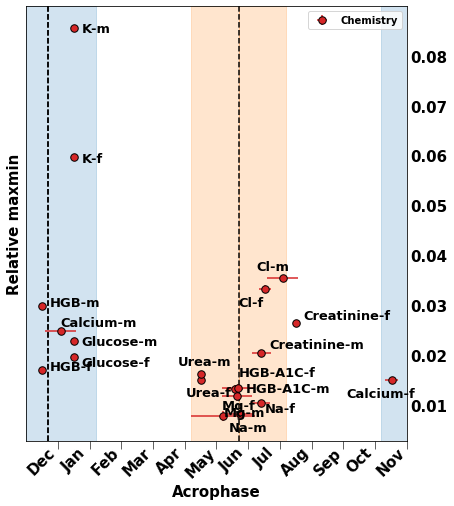

In [19]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
uy = 0.085/100
ux = 12/100
chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
            (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(0,0),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
# chem_loc = [(0,0) for i in chem_names] 

chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (15,8))   
axbig = plt.subplot(1,2,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color=def_color[3],
           loc_list=chem_loc,fontsize=13)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =15)
axbig.tick_params(which='major', length=0,labelsize =15)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 15,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 15,'fontweight':'bold'})

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,12,1))
axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=15,fontweight='bold',minor =False)
axbig.set_xlim([-0.5,11.5])
# axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

plt.savefig('../figures/Seasonality11022020/SI_Chem_phase_amp_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()

# dec21 = 0.2
# jun21 = 6.2
# dec21B = 12.2
# def distance_from_solstice(acrophases_list):
#     return [np.min(np.abs([dD1,dD2,dJ])) for dD1,dD2,dJ in zip(np.array(acrophases_list) - dec21,np.array(acrophases_list) - dec21B,np.array(acrophases_list) - jun21)]

# Dche = []; Deff = []; Dpit = []

# for bootstrap in range(1000):
#     chem_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(chem_acrophase,np.abs(chem_acrophase_std))])
#     Dche += distance_from_solstice(chem_acrophase_boot)

#     eff_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(eff_acrophase,np.abs(eff_acrophase_std))])
#     Deff += distance_from_solstice(eff_acrophase_boot)
    
#     pit_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(pit_acrophase,np.abs(pit_acrophase_std))])
#     Dpit += distance_from_solstice(pit_acrophase_boot)
   
# eff_weights = np.ones_like(Deff)/float(len(Deff))
# pit_weights = np.ones_like(Dpit)/float(len(Dpit))
# che_weights = np.ones_like(Dche)/float(len(Dche))

# ax1 = plt.subplot(1,2,2);
# ax1.text(-0.02, 1.1, 'B', transform=ax1.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
# ax1.hist(Dche,color=def_color[3],alpha=0.6,bins=20,weights=che_weights);
# ax1.hist(Dpit,color=def_color[1],alpha=0.6,bins=20,weights=pit_weights);
# ax1.hist(Deff,color=def_color[0],alpha=0.6,bins=20,weights=eff_weights); 
# ax1.set_xlim([0,3])
# ax1.legend(['Blood chemistry','Pituitary hormones','Effector hormones'])
# ax1.set_xlabel('Distance from solstice [months]',fontsize=15,fontweight='bold')
# ax1.set_ylabel('density',fontsize=15,fontweight='bold')
# ax1.tick_params(axis='x',labelsize =15)
# ax1.tick_params(axis='y',labelsize =15)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.7)
# plt.savefig('../figures/Seasonality11022020/SI_Chem_phase_amp_1102.png',bbox_inches='tight',dpi=600)
# plt.show()

# print('effector & chemistry, ', stats.ks_2samp(Deff, Dche))
# print('pituitary & chemistry, ',stats.ks_2samp(Dpit, Deff))
# print('Chem distance from solstice (mean, std)',[np.mean(Dche),np.std(Dche)])
# print('Hormone distance from solstice (mean, std)',[np.mean(Dpit +Deff),np.std(Dpit +Deff)])

In [22]:
table = []
for key in pituitary_list.keys():
    for sex in ['female','male']:
        table.append([key] + [sex] + [pituitary_list[key][sex]['Clalit']['ntot']] + [pituitary_list[key][sex]['Clalit']['yloc'].mean()] + [pituitary_list[key][sex]['Clalit']['err'].mean()] + pituitary_list[key][sex]['Cosinor']['pars'][0] + pituitary_list[key][sex]['Cosinor2']['pars'][0] + pituitary_list[key][sex]['Cosinor']['pars'][1] + pituitary_list[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df    = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])

table = []
for key in effector_list.keys():
    for sex in ['female','male']:
        table.append([key] + [sex] + [effector_list[key][sex]['Clalit']['ntot']] + [effector_list[key][sex]['Clalit']['yloc'].mean()] + [effector_list[key][sex]['Clalit']['err'].mean()] + effector_list[key][sex]['Cosinor']['pars'][0] + effector_list[key][sex]['Cosinor2']['pars'][0] + effector_list[key][sex]['Cosinor']['pars'][1] + effector_list[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df2 = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])
df = pd.concat([df2,df])
df = df.drop(columns = ['acrophase2','maxmin2','M','Merr'])
df[df.columns[3:]] = df[df.columns[3:]].astype(float)
print('Table S1')
# display(df[['hormone','sex','n','M','Merr','phase','phase_std','amp','amp_std','phase2','phase2_std','amp2','amp2_std','maxmin','maxmin_std','acrophase','acrophase_std']])
df_array = df[df.columns[3:]].values 

df_array[df_array>0.00000001] = np.round(df_array[df_array>0.00000001],decimals=9)
df_array[df_array>0.0000001] = np.round(df_array[df_array>0.0000001],decimals=8)
df_array[df_array>0.000001] = np.round(df_array[df_array>0.000001],decimals=7)
df_array[df_array>0.00001] = np.round(df_array[df_array>0.00001],decimals=6)
df_array[df_array>0.0001] = np.round(df_array[df_array>0.0001],decimals=5)
df_array[df_array>0.001] = np.round(df_array[df_array>0.001],decimals=4)
df_array[df_array>0.01] = np.round(df_array[df_array>0.01],decimals=3)
df_array[df_array>0.1] = np.round(df_array[df_array>0.1],decimals=2)

df[df.columns[3:]] = df_array
display(df)

Table S1


,hormone,sex,n,phase,amp,acrophase,maxmin,phase2,amp2,phase_std,amp_std,acrophase_std,maxmin_std,phase2_std,amp2_std,acrophase2_std,maxmin2_std
0,Cortisol,female,63175,3.740000,0.0130,3.37,0.0210,-1.00,0.0000,0.220,0.00160,1.080000e+00,0.00230,-0.000,0.00000,1.080000e+00,0.00230
1,Cortisol,male,21155,3.060000,0.0110,1.56,0.0210,-1.00,0.0000,0.440,0.00260,1.100000e+00,0.00330,-0.000,0.00000,1.100000e+00,0.00330
2,Urinary cortisol,female,12003,1.580000,0.0210,1.86,0.0310,-1.00,0.0000,0.310,0.00340,4.200000e-01,0.00510,-0.000,0.00000,4.200000e-01,0.00510
3,Urinary cortisol,male,5125,-1.000000,0.0000,0.00,0.0000,-1.00,0.0000,0.000,0.00000,0.000000e+00,0.00000,0.000,0.00000,0.000000e+00,0.00000
4,T3-free,female,345945,1.650000,0.0520,1.00,0.0530,-1.00,0.0000,0.023,0.00062,-0.000000e+00,0.00100,-0.000,0.00000,-0.000000e+00,0.00100
5,T3-free,male,162602,1.360000,0.0460,1.00,0.0510,-1.00,0.0000,0.038,0.00086,4.400000e-02,0.00150,-0.000,0.00000,4.400000e-02,0.00150
6,T4-free,female,899982,-0.734861,0.0160,11.00,0.0180,9.98,0.0037,0.050,0.00038,4.000000e-08,0.00065,0.200,0.00038,4.000000e-08,0.00065
7,T4-free,male,422709,10.160000,0.0150,10.17,0.0170,9.58,0.0061,0.074,0.00058,3.800000e-01,0.00086,0.180,0.00058,3.800000e-01,0.00086
8,Estradiol,female,149177,3.440000,0.0039,2.29,0.0073,3.65,0.0033,0.500,0.00100,6.200000e-01,0.00130,0.590,0.00094,6.200000e-01,0.00130
9,Estradiol,male,7554,1.640000,0.0190,2.10,0.0310,-1.00,0.0000,0.470,0.00430,1.540000e+00,0.00570,-0.000,0.00000,1.540000e+00,0.00570


In [18]:
df['phase_str']     = [str(df.iloc[i]['phase']) +'±' + str(df.iloc[i]['phase_std']) for i in range(len(df))]
df['amp_str']       = [str(df.iloc[i]['amp']) +'±' + str(df.iloc[i]['amp_std']) for i in range(len(df))]
df['acrophase_str'] = [str(df.iloc[i]['acrophase']) +'±' + str(df.iloc[i]['acrophase_std']) for i in range(len(df))]
df['maxmin_str']    = [str(df.iloc[i]['maxmin']) +'±' + str(df.iloc[i]['maxmin_std']) for i in range(len(df))]
df['phase2_str']    = [str(df.iloc[i]['phase2']) +'±' + str(df.iloc[i]['phase2_std']) for i in range(len(df))]
df['amp2_str']      = [str(df.iloc[i]['amp2']) +'±' + str(df.iloc[i]['amp2_std']) for i in range(len(df))]

display(df[['phase_str','amp_str','acrophase_str','maxmin_str','phase2_str','amp2_str']])

,phase_str,amp_str,acrophase_str,maxmin_str,phase2_str,amp2_str
0,3.74±0.22,0.013±0.0016,3.37±1.08,0.021±0.0023,-1.0±-0.0,0.0±0.0
1,3.06±0.44,0.011±0.0026,1.56±1.1,0.021±0.0033,-1.0±-0.0,0.0±0.0
2,1.58±0.31,0.021±0.0034,1.86±0.42,0.031±0.0051,-1.0±-0.0,0.0±0.0
3,-1.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,-1.0±0.0,0.0±0.0
4,1.65±0.023,0.052±0.00062,1.0±-0.0,0.053±0.001,-1.0±-0.0,0.0±0.0
5,1.36±0.038,0.046±0.00086,1.0±0.044,0.051±0.0015,-1.0±-0.0,0.0±0.0
6,-0.7348613299644746±0.05,0.016±0.00038,11.0±4e-08,0.018±0.00065,9.98±0.2,0.0037±0.00038
7,10.16±0.074,0.015±0.00058,10.17±0.38,0.017±0.00086,9.58±0.18,0.0061±0.00058
8,3.44±0.5,0.0039±0.001,2.29±0.62,0.0073±0.0013,3.65±0.59,0.0033±0.00094
9,1.64±0.47,0.019±0.0043,2.1±1.54,0.031±0.0057,-1.0±-0.0,0.0±0.0


In [ ]:
# clalit_ukb ={'TESTOSTERONE_TOTAL':'Testosterone',
#             'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF-1',
#             'CALCIUM_BLOOD':'Calcium',
#             'CREATININE_BLOOD':'Creatinine',
#             'GLUCOSE_BLOOD':'Glucose',
#             'HEMOGLOBIN_A1C_CALCULATED':'Glycated haemoglobin (HbA1c)',
#             'HGB':'Haemoglobin concentration',
#             'UREA_BLOOD':'Urea'}
# clalit_ukb_list  = gen_hormone_list(clalit_ukb)
# pickle.dump([clalit_ukb_list],open('seasonality_processed_data04_clalit_ukb.pickle','wb'))